In [ ]:
#!pip install librosa

# Importar funciones necesarias

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torchaudio
import librosa

import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Función para crear los Datasets

In [3]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house',
 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
 'two', 'up', 'visual', 'wow', 'yes', 'zero']

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or "Spectrogram (db)")
  axs.set_ylabel(ylabel)
  axs.set_xlabel("frame")
  im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
  fig.colorbar(im, ax=axs)
  plt.show(block=False)



class Create_DataSet(SPEECHCOMMANDS):
  def __init__(self, subset: str = None, ventanas: int = 2048):
    super().__init__("./", download=True)

    self.ventanas = ventanas
    self.subset = subset

    def load_list(filename):
        filepath = os.path.join(self._path, filename)
        with open(filepath) as fileobj:
            return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

    if subset == "validation":
        self._walker = load_list("validation_list.txt")
    elif subset == "testing":
        self._walker = load_list("testing_list.txt")
    elif subset == "training":
        excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
        excludes = set(excludes)
        self._walker = [w for w in self._walker if w not in excludes]


  def get_item_info(self, filepath: str, path: str):
      relpath = os.path.relpath(filepath, path)
      label, filename = os.path.split(relpath)
      speaker, _ = os.path.splitext(filename)
      speaker, _ = os.path.splitext(speaker)

      speaker_id, utterance_number = speaker.split("_nohash_")
      utterance_number = int(utterance_number)

      # Load audio
      waveform, sample_rate = torchaudio.load(filepath)
      

      largo = waveform.shape[1]
      if largo != 16000:
        pad = (16000 - largo-1, 1)
        waveform = F.pad(waveform, pad, value=0)


      # quitar offset de la señal
      waveform = waveform + abs(waveform.mean())


      # MFCC
      n_mfcc = 13
      n_fft = self.ventanas
      win_length = None
      hop_length = int(self.ventanas/2)
      n_mels = 13
      args={"n_fft": n_fft, "n_mels": n_mels, "hop_length": hop_length, "mel_scale": "htk"}

      mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc, melkwargs=args)
      MFCC = mfcc_transform(waveform)


      # Delta
      delta_transform = T.ComputeDeltas()
      Delta = delta_transform(MFCC[0])


      # Delta Delta
      Delta_Delta = delta_transform(Delta)


      clase = torch.tensor(labels.index(label))

      return waveform, MFCC[0], Delta, Delta_Delta, clase





  def __getitem__(self, n: int):
    
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)
    #return torch.cat((info[1], info[2], info[3]), 1), info[4]
    return info[1].T, info[4]


  def plot_wf_and_features(self, n):
    
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)

    plt.plot(info[0].t().numpy())
    plt.title(f"Waveform subset {self.subset}[{n}]")
    plot_spectrogram(info[1], title = f"MFCC subset {self.subset}[{n}]")
    plot_spectrogram(info[2], title = f"Delta subset {self.subset}[{n}]")
    plot_spectrogram(info[3], title = f"Delta-Delta subset {self.subset}[{n}]")

  def get_waveform(self, n: int):
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)

    return info[0]

Crear los Datasets

In [4]:
# Create training, validation and testing split of the data.

train_dataset = Create_DataSet("training")
val_dataset = Create_DataSet("validation")
test_dataset = Create_DataSet("testing")

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [5]:
train_dataset[0][0].shape

torch.Size([16, 13])

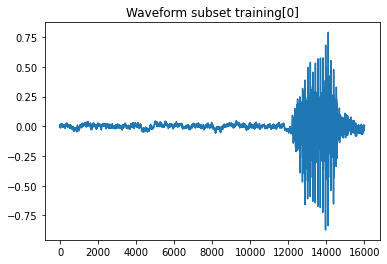

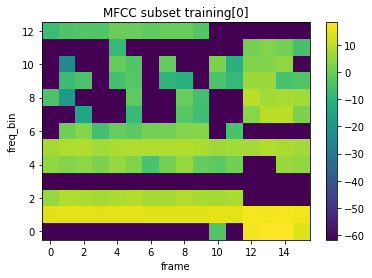

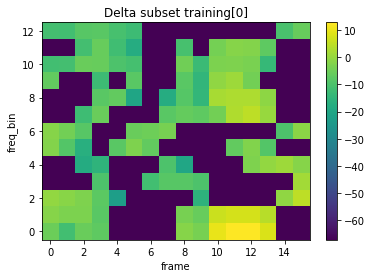

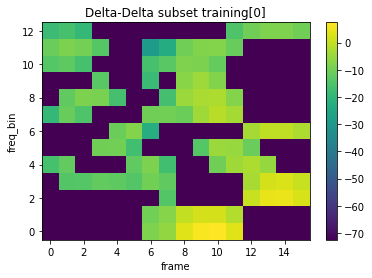

In [6]:
train_dataset.plot_wf_and_features(0)

# Modelos

In [7]:
class RNNModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=128,
        num_layers=1,
    ):
        super().__init__()

        self.rnn_layer = nn.RNN(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, 35),
        )

        self.flatten_layer = nn.Flatten()

    def forward(self, x):
        
        out, h = self.rnn_layer(x)
            
        out = h[-1]

        return self.net(out)

In [8]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=128,
        num_layers=1,
    ):
        super().__init__()

        self.rnn_layer = nn.LSTM(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, 35),
        )

        self.flatten_layer = nn.Flatten()

    def forward(self, x):
        
        out, (h, c) = self.rnn_layer(x)
            
        out = h[-1]

        return self.net(out)

In [9]:
class GRUModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=128,
        num_layers=1,
    ):
        super().__init__()

        self.rnn_layer = nn.GRU(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, 35),
        )

        self.flatten_layer = nn.Flatten()

    def forward(self, x):
        
        out, h = self.rnn_layer(x)
            
        out = h[-1]

        return self.net(out)

#Entrenamiento

## Funciones para entrenar

In [10]:
import time

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report

In [11]:
def show_curves(all_curves):

    final_curve_means = {k: np.mean([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}
    final_curve_stds = {k: np.std([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}

    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(final_curve_means["val_loss"])) + 1

    ax[0].plot(epochs, final_curve_means['val_loss'], label='validation')
    ax[0].plot(epochs, final_curve_means['train_loss'], label='training')
    ax[0].fill_between(epochs, y1=final_curve_means["val_loss"] - final_curve_stds["val_loss"], y2=final_curve_means["val_loss"] + final_curve_stds["val_loss"], alpha=.5)
    ax[0].fill_between(epochs, y1=final_curve_means["train_loss"] - final_curve_stds["train_loss"], y2=final_curve_means["train_loss"] + final_curve_stds["train_loss"], alpha=.5)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, final_curve_means['val_acc'], label='validation')
    ax[1].plot(epochs, final_curve_means['train_acc'], label='training')
    ax[1].fill_between(epochs, y1=final_curve_means["val_acc"] - final_curve_stds["val_acc"], y2=final_curve_means["val_acc"] + final_curve_stds["val_acc"], alpha=.5)
    ax[1].fill_between(epochs, y1=final_curve_means["train_acc"] - final_curve_stds["train_acc"], y2=final_curve_means["train_acc"] + final_curve_stds["train_acc"], alpha=.5)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

def get_metrics_and_confusion_matrix(model, dataset):
    model.cpu()
    model.eval()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=min(16, len(dataset)))
    y_true = []
    y_pred = []
    for x, y in dataloader:
        y_true.append(y)
        y_pred.append(model(x).argmax(dim=1))

    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)


    print(classification_report(y_true, y_pred, zero_division=0))

    print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")
    
    fig, ax = plt.subplots(figsize=(8, 7))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, xticks_rotation="vertical", include_values=False, ax=ax)
    plt.show()

In [12]:
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

In [13]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item() * y_val.shape[0]
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / data_count

    return val_acc, val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    early_stopping_tolerance=15,
    n_evaluations_per_epoch=6,
    use_gpu=False,
):
    if use_gpu:
        model.cuda()


    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)
    print(n_batches)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        examples_count = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item() * x_batch.shape[0]
            examples_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / examples_count
                train_acc = cumulative_train_corrects / examples_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / examples_count
        train_acc = cumulative_train_corrects / examples_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)


        if early_stopping(val_loss):
            print("Early stopping.")
            break

    print()
    total_time = time.perf_counter() - t0
    print(f"Tiempo total de entrenamiento: {total_time:.4f} [s]")

    model.cpu()

    return curves, total_time

## Entrenamiento con ventanas de 2048

In [14]:
# Create training, validation and testing split of the data.

train_dataset_2048 = Create_DataSet("training", 2048)
val_dataset_2048 = Create_DataSet("validation", 2048)
test_dataset_2048 = Create_DataSet("testing", 2048)

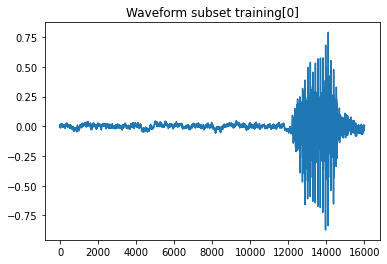

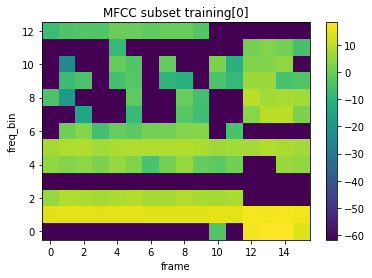

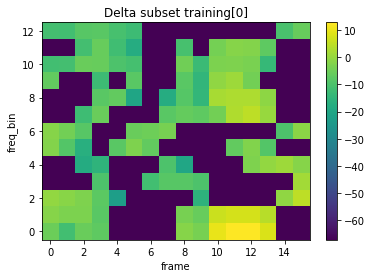

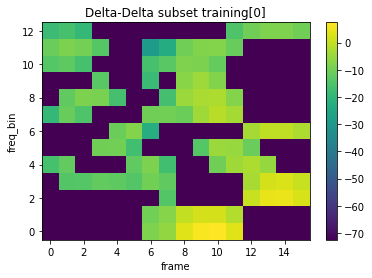

In [15]:
# Gráfico de onda y features del primer elemento del conjunto de entrenamiento
train_dataset_2048.plot_wf_and_features(0)

5303
Epoch 1/50
Iteration 883 - Batch 883/5303 - Train loss: 3.506184687172126, Train acc: 0.04383484162895927
Iteration 1766 - Batch 1766/5303 - Train loss: 3.469972046877478, Train acc: 0.053904923599320885
Iteration 2649 - Batch 2649/5303 - Train loss: 3.435338863696692, Train acc: 0.06306603773584905
Iteration 3532 - Batch 3532/5303 - Train loss: 3.386166567374585, Train acc: 0.07233583356920464
Iteration 4415 - Batch 4415/5303 - Train loss: 3.3265326885317545, Train acc: 0.08179064764492754
Iteration 5298 - Batch 5298/5303 - Train loss: 3.2746937166949355, Train acc: 0.09094876391772032
Val loss: 2.939893673947526, Val acc: 0.1602043883378419
Epoch 2/50
Iteration 6186 - Batch 883/5303 - Train loss: 2.9303931914843044, Train acc: 0.15921945701357465
Iteration 7069 - Batch 1766/5303 - Train loss: 2.898659732021986, Train acc: 0.16312959818902095
Iteration 7952 - Batch 2649/5303 - Train loss: 2.8614194277097593, Train acc: 0.17125
Iteration 8835 - Batch 3532/5303 - Train loss: 2.8231

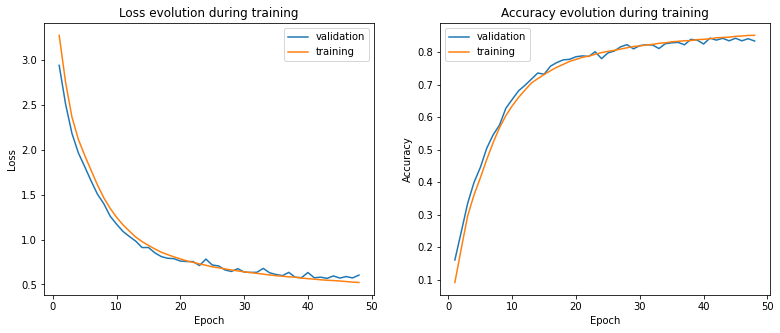

In [ ]:
lr = 1e-4 
batch_size = 16
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_rnn_2048 = RNNModel(13)

    curves, total_time = train_model(
        model_rnn_2048,
        train_dataset_2048,
        val_dataset_2048,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       165
           1       0.75      0.62      0.68       207
           2       0.84      0.73      0.78       185
           3       0.74      0.81      0.77       194
           4       0.78      0.72      0.75       220
           5       0.81      0.78      0.80       406
           6       0.88      0.86      0.87       408
           7       0.78      0.86      0.81       445
           8       0.72      0.61      0.66       172
           9       0.62      0.62      0.62       155
          10       0.75      0.81      0.78       400
          11       0.61      0.74      0.67       402
          12       0.82      0.88      0.85       203
          13       0.87      0.87      0.87       191
          14       0.70      0.56      0.62       161
          15       0.84      0.84      0.84       412
          16       0.80      0.72      0.75       195
          17       0.94    

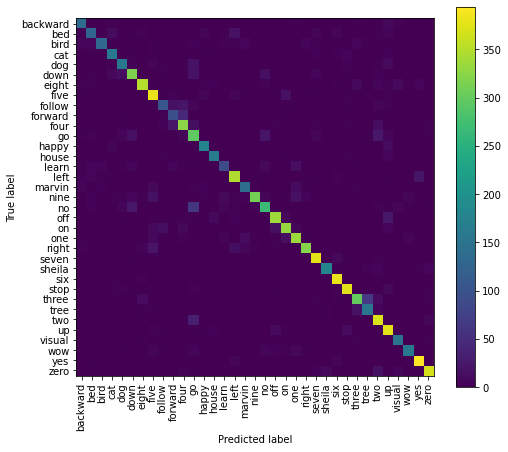

In [ ]:
get_metrics_and_confusion_matrix(model_rnn_2048, test_dataset_2048)

5303
Epoch 1/50
Iteration 883 - Batch 883/5303 - Train loss: 3.4501606967654164, Train acc: 0.08173076923076923
Iteration 1766 - Batch 1766/5303 - Train loss: 3.2790771139228014, Train acc: 0.13660158460667798
Iteration 2649 - Batch 2649/5303 - Train loss: 3.0850730443900485, Train acc: 0.18841981132075472
Iteration 3532 - Batch 3532/5303 - Train loss: 2.9024471635356894, Train acc: 0.2362015284460798
Iteration 4415 - Batch 4415/5303 - Train loss: 2.7351019949908704, Train acc: 0.27928272192028986
Iteration 5298 - Batch 5298/5303 - Train loss: 2.5854816122715554, Train acc: 0.31691120966220043
Val loss: 1.6638868678704184, Val acc: 0.5577597435126741
Epoch 2/50
Iteration 6186 - Batch 883/5303 - Train loss: 1.6025747251591531, Train acc: 0.5697822398190046
Iteration 7069 - Batch 1766/5303 - Train loss: 1.5295280161454439, Train acc: 0.5900891341256367
Iteration 7952 - Batch 2649/5303 - Train loss: 1.464432754966448, Train acc: 0.6079716981132075
Iteration 8835 - Batch 3532/5303 - Train 

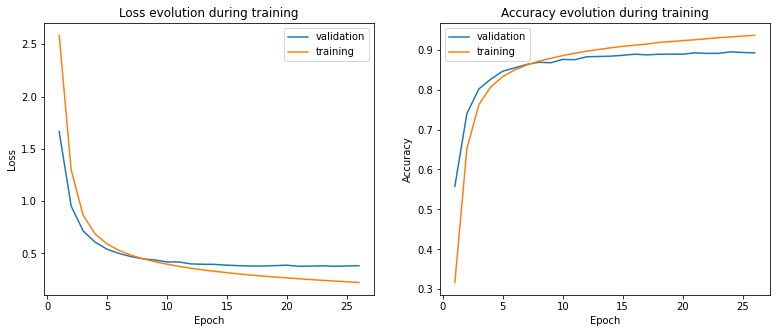

In [ ]:
lr = 1e-4 
batch_size = 16
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_lstm_2048 = LSTMModel(13)

    curves, total_time = train_model(
        model_lstm_2048,
        train_dataset_2048,
        val_dataset_2048,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       165
           1       0.80      0.82      0.81       207
           2       0.90      0.81      0.85       185
           3       0.88      0.85      0.86       194
           4       0.83      0.81      0.82       220
           5       0.88      0.84      0.86       406
           6       0.85      0.93      0.89       408
           7       0.94      0.89      0.91       445
           8       0.90      0.71      0.79       172
           9       0.69      0.72      0.70       155
          10       0.84      0.86      0.85       400
          11       0.78      0.79      0.78       402
          12       0.93      0.90      0.91       203
          13       0.94      0.88      0.91       191
          14       0.70      0.72      0.71       161
          15       0.84      0.93      0.88       412
          16       0.94      0.88      0.91       195
          17       0.91    

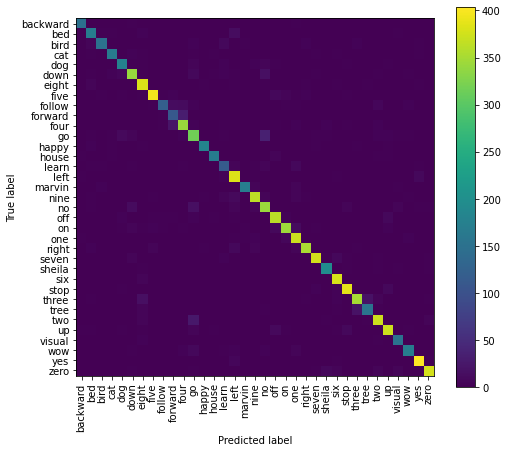

In [ ]:
get_metrics_and_confusion_matrix(model_lstm_2048, test_dataset_2048)

5303
Epoch 1/50
Iteration 883 - Batch 883/5303 - Train loss: 3.2818111262170437, Train acc: 0.12351527149321267
Iteration 1766 - Batch 1766/5303 - Train loss: 3.0359445027058314, Train acc: 0.20002122241086587
Iteration 2649 - Batch 2649/5303 - Train loss: 2.8156255383311577, Train acc: 0.25707547169811323
Iteration 3532 - Batch 3532/5303 - Train loss: 2.6224706595388714, Train acc: 0.30736979903764505
Iteration 4415 - Batch 4415/5303 - Train loss: 2.4525786304063555, Train acc: 0.35183140851449274
Iteration 5298 - Batch 5298/5303 - Train loss: 2.2990751831930614, Train acc: 0.3933643140215135
Val loss: 1.3899594751750166, Val acc: 0.637611461777377
Epoch 2/50
Iteration 6186 - Batch 883/5303 - Train loss: 1.3636203522865589, Train acc: 0.6496747737556561
Iteration 7069 - Batch 1766/5303 - Train loss: 1.2969554546665998, Train acc: 0.6635894170911149
Iteration 7952 - Batch 2649/5303 - Train loss: 1.2400395408666358, Train acc: 0.6771226415094339
Iteration 8835 - Batch 3532/5303 - Train 

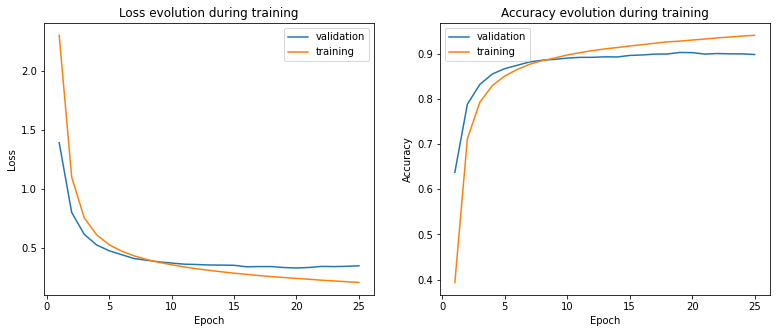

In [ ]:
lr = 1e-4 
batch_size = 16
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_gru_2048 = GRUModel(13)

    curves, total_time = train_model(
        model_gru_2048,
        train_dataset_2048,
        val_dataset_2048,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       165
           1       0.84      0.86      0.85       207
           2       0.89      0.88      0.88       185
           3       0.86      0.89      0.87       194
           4       0.94      0.77      0.84       220
           5       0.88      0.85      0.87       406
           6       0.94      0.91      0.92       408
           7       0.88      0.93      0.90       445
           8       0.84      0.70      0.77       172
           9       0.74      0.70      0.72       155
          10       0.86      0.86      0.86       400
          11       0.77      0.88      0.82       402
          12       0.91      0.90      0.90       203
          13       0.89      0.93      0.91       191
          14       0.77      0.80      0.78       161
          15       0.88      0.91      0.90       412
          16       0.94      0.88      0.91       195
          17       0.88    

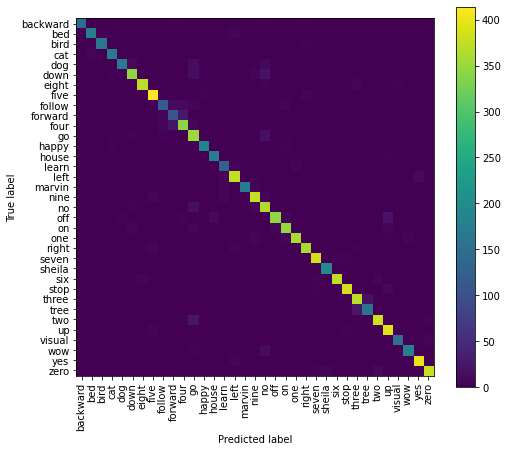

In [ ]:
get_metrics_and_confusion_matrix(model_gru_2048, test_dataset_2048)

## Entrenamiento con ventanas de 1024

In [16]:
# Create training, validation and testing split of the data.

train_dataset_1024 = Create_DataSet("training", 1024)
val_dataset_1024 = Create_DataSet("validation", 1024)
test_dataset_1024 = Create_DataSet("testing", 1024)

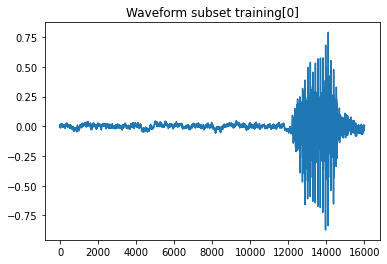

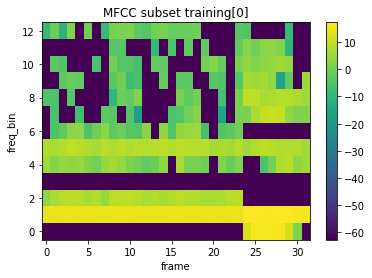

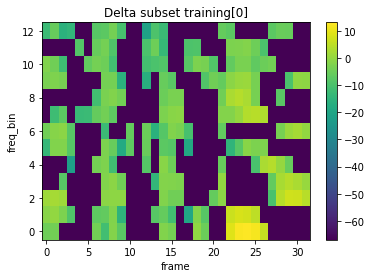

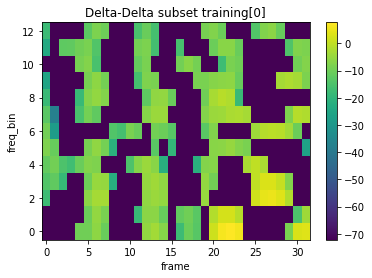

In [17]:
# Gráfico de onda y features del primer elemento del conjunto de entrenamiento
train_dataset_1024.plot_wf_and_features(0)

2652
Epoch 1/50
Iteration 442 - Batch 442/2652 - Train loss: 3.5373001873627743, Train acc: 0.03809255079006772
Iteration 884 - Batch 884/2652 - Train loss: 3.5171338657874847, Train acc: 0.041666666666666664
Iteration 1326 - Batch 1326/2652 - Train loss: 3.503241777420044, Train acc: 0.044272795779954785
Iteration 1768 - Batch 1768/2652 - Train loss: 3.493715909458676, Train acc: 0.0464951950254381
Iteration 2210 - Batch 2210/2652 - Train loss: 3.4868492424515027, Train acc: 0.048606399819086384
Val loss: 3.4380072666401733, Val acc: 0.06081554954413385
Epoch 2/50
Iteration 3094 - Batch 442/2652 - Train loss: 3.43035914881773, Train acc: 0.05925507900677201
Iteration 3536 - Batch 884/2652 - Train loss: 3.418724303326364, Train acc: 0.06331214689265537
Iteration 3978 - Batch 1326/2652 - Train loss: 3.3849974400851632, Train acc: 0.06796345139412208
Iteration 4420 - Batch 1768/2652 - Train loss: 3.3564410177309543, Train acc: 0.07304621254946297
Iteration 4862 - Batch 2210/2652 - Train 

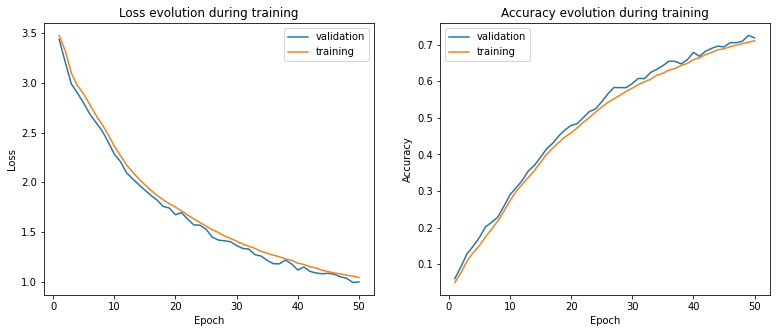

In [ ]:
lr = 1e-4 
batch_size = 32
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_rnn_1024 = RNNModel(13)

    curves, total_time = train_model(
        model_rnn_1024,
        train_dataset_1024,
        val_dataset_1024,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.69      0.56      0.62       165
           1       0.50      0.63      0.56       207
           2       0.76      0.65      0.70       185
           3       0.39      0.65      0.49       194
           4       0.60      0.61      0.61       220
           5       0.61      0.76      0.68       406
           6       0.80      0.81      0.80       408
           7       0.81      0.72      0.76       445
           8       0.47      0.37      0.42       172
           9       0.62      0.39      0.48       155
          10       0.68      0.70      0.69       400
          11       0.48      0.39      0.43       402
          12       0.74      0.82      0.78       203
          13       0.85      0.81      0.83       191
          14       0.45      0.36      0.40       161
          15       0.63      0.78      0.69       412
          16       0.78      0.53      0.63       195
          17       0.68    

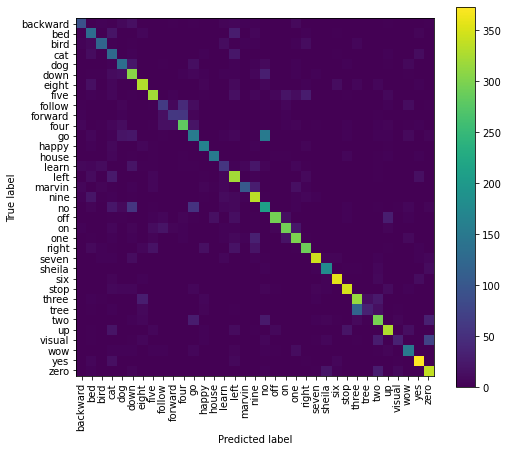

In [ ]:
get_metrics_and_confusion_matrix(model_rnn_1024, test_dataset_1024)

2652
Epoch 1/50
Iteration 442 - Batch 442/2652 - Train loss: 3.4903620801714688, Train acc: 0.05692720090293454
Iteration 884 - Batch 884/2652 - Train loss: 3.386411276240807, Train acc: 0.09399717514124294
Iteration 1326 - Batch 1326/2652 - Train loss: 3.2768097937152003, Train acc: 0.13173511680482292
Iteration 1768 - Batch 1768/2652 - Train loss: 3.1684858766634494, Train acc: 0.1635987846240814
Iteration 2210 - Batch 2210/2652 - Train loss: 3.057066545180205, Train acc: 0.19315355042966983
Val loss: 2.254301964024386, Val acc: 0.40777477206692714
Epoch 2/50
Iteration 3094 - Batch 442/2652 - Train loss: 2.2010502987467677, Train acc: 0.4090716704288939
Iteration 3536 - Batch 884/2652 - Train loss: 2.108284394215729, Train acc: 0.43125
Iteration 3978 - Batch 1326/2652 - Train loss: 2.022797356176484, Train acc: 0.45068764129615674
Iteration 4420 - Batch 1768/2652 - Train loss: 1.9488669798291962, Train acc: 0.4686793386093838
Iteration 4862 - Batch 2210/2652 - Train loss: 1.876639860

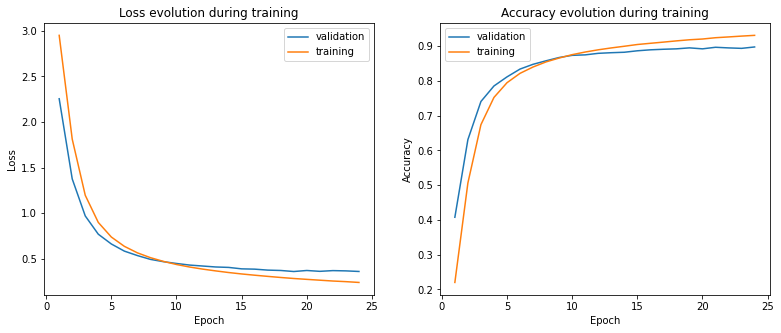

In [ ]:
lr = 1e-4 
batch_size = 32
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_lstm_1024 = LSTMModel(13)

    curves, total_time = train_model(
        model_lstm_1024,
        train_dataset_1024,
        val_dataset_1024,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       165
           1       0.81      0.84      0.83       207
           2       0.87      0.83      0.85       185
           3       0.85      0.84      0.85       194
           4       0.90      0.80      0.84       220
           5       0.87      0.85      0.86       406
           6       0.91      0.92      0.91       408
           7       0.89      0.91      0.90       445
           8       0.81      0.73      0.77       172
           9       0.79      0.66      0.72       155
          10       0.81      0.85      0.83       400
          11       0.79      0.82      0.80       402
          12       0.91      0.87      0.89       203
          13       0.92      0.89      0.91       191
          14       0.83      0.70      0.76       161
          15       0.87      0.92      0.89       412
          16       0.94      0.89      0.91       195
          17       0.89    

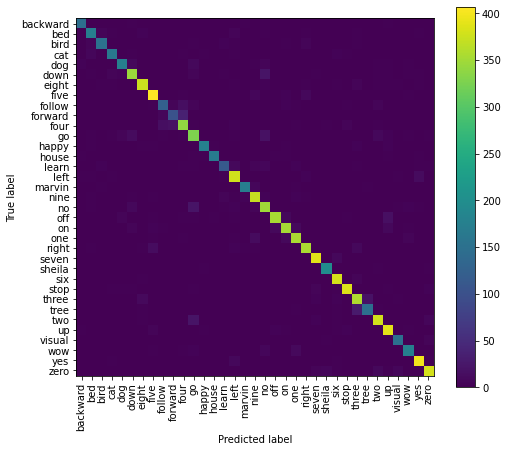

In [ ]:
get_metrics_and_confusion_matrix(model_lstm_1024, test_dataset_1024)

2652
Epoch 1/50
Iteration 442 - Batch 442/2652 - Train loss: 3.4056719167506992, Train acc: 0.08690744920993228
Iteration 884 - Batch 884/2652 - Train loss: 3.2528234128898146, Train acc: 0.1425494350282486
Iteration 1326 - Batch 1326/2652 - Train loss: 3.104765325178306, Train acc: 0.188112283345893
Iteration 1768 - Batch 1768/2652 - Train loss: 2.9671700367353404, Train acc: 0.22779465799886942
Iteration 2210 - Batch 2210/2652 - Train loss: 2.833765101508283, Train acc: 0.2646144278606965
Val loss: 1.9367977381349744, Val acc: 0.5100691313495642
Epoch 2/50
Iteration 3094 - Batch 442/2652 - Train loss: 1.8904679443174237, Train acc: 0.5081828442437923
Iteration 3536 - Batch 884/2652 - Train loss: 1.8046818035470564, Train acc: 0.5341454802259887
Iteration 3978 - Batch 1326/2652 - Train loss: 1.7221559091178473, Train acc: 0.5569423511680482
Iteration 4420 - Batch 1768/2652 - Train loss: 1.6462734840966133, Train acc: 0.576861927642736
Iteration 4862 - Batch 2210/2652 - Train loss: 1.5

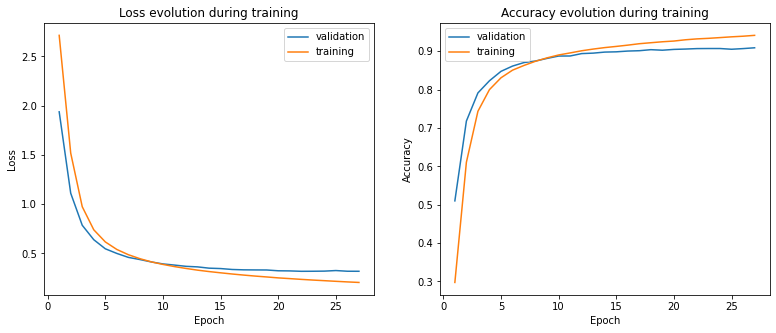

In [ ]:
lr = 1e-4 
batch_size = 32
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_gru_1024 = GRUModel(13)

    curves, total_time = train_model(
        model_gru_1024,
        train_dataset_1024,
        val_dataset_1024,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       165
           1       0.81      0.86      0.83       207
           2       0.81      0.86      0.83       185
           3       0.84      0.92      0.87       194
           4       0.87      0.85      0.86       220
           5       0.86      0.86      0.86       406
           6       0.93      0.92      0.93       408
           7       0.94      0.93      0.93       445
           8       0.88      0.67      0.76       172
           9       0.74      0.72      0.73       155
          10       0.85      0.86      0.86       400
          11       0.82      0.87      0.84       402
          12       0.89      0.89      0.89       203
          13       0.92      0.92      0.92       191
          14       0.76      0.81      0.79       161
          15       0.92      0.92      0.92       412
          16       0.92      0.88      0.90       195
          17       0.92    

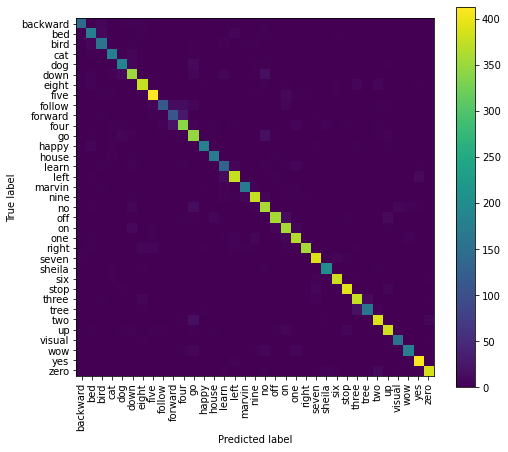

In [ ]:
get_metrics_and_confusion_matrix(model_gru_1024, test_dataset_1024)

## Entrenamiento con ventanas de 512

In [ ]:
# Create training, validation and testing split of the data.

train_dataset_512 = Create_DataSet("training", 512)
val_dataset_512 = Create_DataSet("validation", 512)
test_dataset_512 = Create_DataSet("testing", 512)

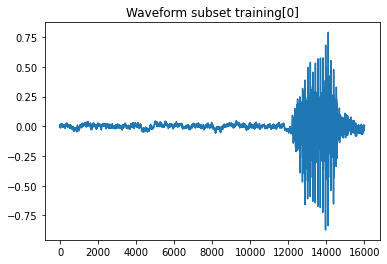

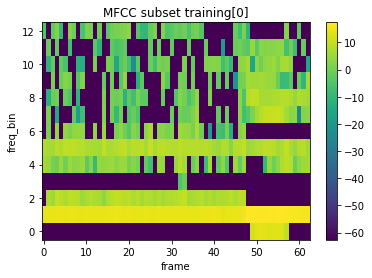

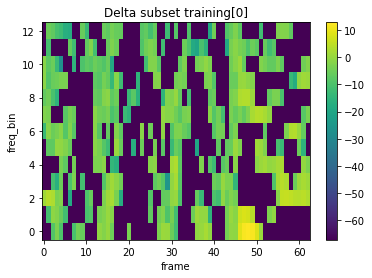

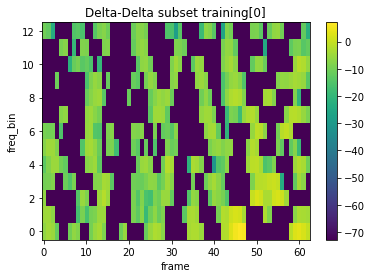

In [ ]:
# Gráfico de onda y features del primer elemento del conjunto entrenamiento
train_dataset_512.plot_wf_and_features(0)

1347
Epoch 1/50
Iteration 224 - Batch 224/1347 - Train loss: 3.5473452250162762, Train acc: 0.03746031746031746
Iteration 448 - Batch 448/1347 - Train loss: 3.520959120816271, Train acc: 0.03994767914589741
Iteration 672 - Batch 672/1347 - Train loss: 3.5085200267950456, Train acc: 0.042618929691738014
Iteration 896 - Batch 896/1347 - Train loss: 3.501342030804824, Train acc: 0.043655217568261045
Iteration 1120 - Batch 1120/1347 - Train loss: 3.496163758499935, Train acc: 0.044532234541155145
Iteration 1344 - Batch 1344/1347 - Train loss: 3.491175971509799, Train acc: 0.04554198383194666
Val loss: 3.462037934388418, Val acc: 0.05410279531109107
Epoch 2/50
Iteration 1571 - Batch 224/1347 - Train loss: 3.459961666531033, Train acc: 0.05368606701940035
Iteration 1795 - Batch 448/1347 - Train loss: 3.4573251882480887, Train acc: 0.054371265952557715
Iteration 2019 - Batch 672/1347 - Train loss: 3.453922504478897, Train acc: 0.054789028043114224
Iteration 2243 - Batch 896/1347 - Train loss:

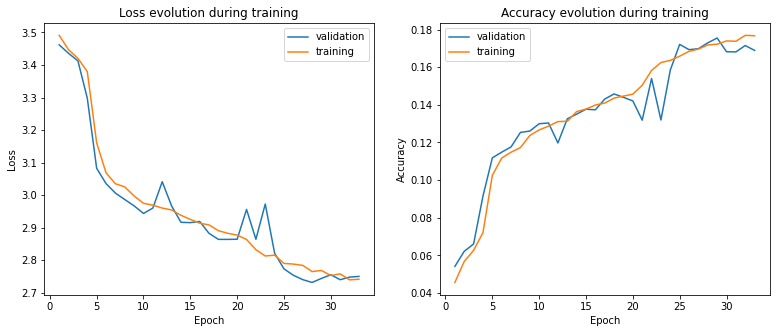

In [ ]:
lr = 1e-4 
batch_size = 63
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_rnn_512 = RNNModel(13)

    curves, total_time = train_model(
        model_rnn_512,
        train_dataset_512,
        val_dataset_512,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.07      0.02      0.04       165
           1       0.15      0.02      0.04       207
           2       0.06      0.02      0.03       185
           3       0.09      0.01      0.02       194
           4       0.19      0.03      0.05       220
           5       0.09      0.20      0.12       406
           6       0.27      0.21      0.23       408
           7       0.16      0.06      0.08       445
           8       0.04      0.01      0.01       172
           9       0.05      0.01      0.02       155
          10       0.11      0.12      0.12       400
          11       0.11      0.16      0.13       402
          12       0.21      0.03      0.06       203
          13       0.31      0.31      0.31       191
          14       0.00      0.00      0.00       161
          15       0.15      0.01      0.02       412
          16       0.00      0.00      0.00       195
          17       0.14    

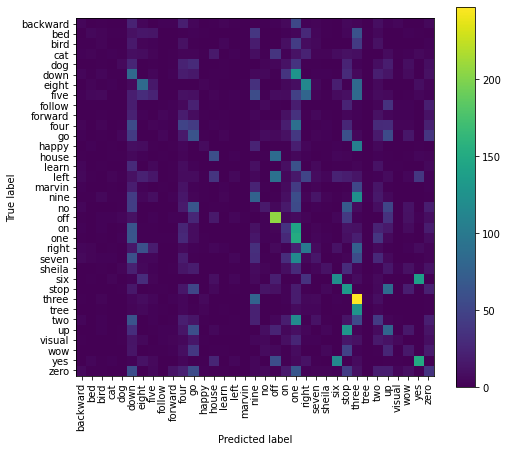

In [ ]:
get_metrics_and_confusion_matrix(model_rnn_512, test_dataset_512)

1347
Epoch 1/50
Iteration 224 - Batch 224/1347 - Train loss: 3.506479852464464, Train acc: 0.05347442680776014
Iteration 448 - Batch 448/1347 - Train loss: 3.4504620981110232, Train acc: 0.07600664616254817
Iteration 672 - Batch 672/1347 - Train loss: 3.3867790546672305, Train acc: 0.09809193613056912
Iteration 896 - Batch 896/1347 - Train loss: 3.318951375508388, Train acc: 0.11585355063615933
Iteration 1120 - Batch 1120/1347 - Train loss: 3.2502848748965096, Train acc: 0.13395069594891182
Iteration 1344 - Batch 1344/1347 - Train loss: 3.184539761064664, Train acc: 0.15020947660352865
Val loss: 2.759233361541741, Val acc: 0.2660054102795311
Epoch 2/50
Iteration 1571 - Batch 224/1347 - Train loss: 2.7330016899108887, Train acc: 0.26462081128747794
Iteration 1795 - Batch 448/1347 - Train loss: 2.684005216394607, Train acc: 0.2851133029306749
Iteration 2019 - Batch 672/1347 - Train loss: 2.634327621374938, Train acc: 0.2994174390905446
Iteration 2243 - Batch 896/1347 - Train loss: 2.5842

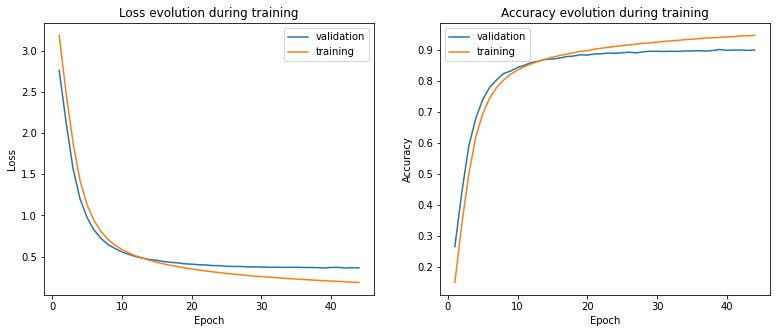

In [ ]:
lr = 1e-4 
batch_size = 63
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_lstm_512 = LSTMModel(13)

    curves, total_time = train_model(
        model_lstm_512,
        train_dataset_512,
        val_dataset_512,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       165
           1       0.83      0.81      0.82       207
           2       0.85      0.85      0.85       185
           3       0.87      0.87      0.87       194
           4       0.86      0.84      0.85       220
           5       0.86      0.84      0.85       406
           6       0.89      0.91      0.90       408
           7       0.92      0.91      0.91       445
           8       0.79      0.76      0.77       172
           9       0.71      0.71      0.71       155
          10       0.83      0.84      0.83       400
          11       0.78      0.85      0.81       402
          12       0.91      0.89      0.90       203
          13       0.91      0.95      0.93       191
          14       0.72      0.73      0.72       161
          15       0.88      0.93      0.91       412
          16       0.92      0.89      0.90       195
          17       0.90    

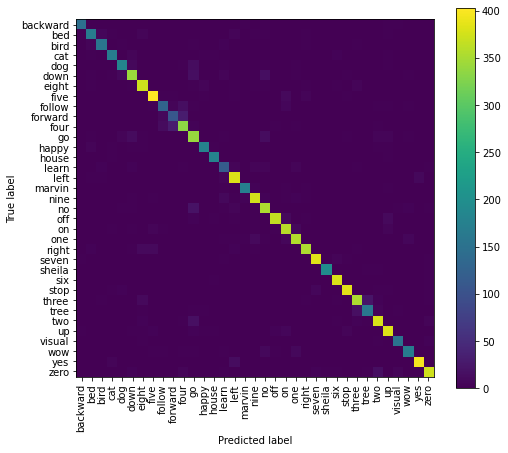

In [ ]:
get_metrics_and_confusion_matrix(model_lstm_512, test_dataset_512)

1347
Epoch 1/50
Iteration 224 - Batch 224/1347 - Train loss: 3.4903682602776422, Train acc: 0.057566137566137564
Iteration 448 - Batch 448/1347 - Train loss: 3.3708060377159206, Train acc: 0.10775267790857991
Iteration 672 - Batch 672/1347 - Train loss: 3.2624885316766568, Train acc: 0.14554588551616784
Iteration 896 - Batch 896/1347 - Train loss: 3.1590641196090377, Train acc: 0.17630195891065456
Iteration 1120 - Batch 1120/1347 - Train loss: 3.0586839251811755, Train acc: 0.20473500134517084
Iteration 1344 - Batch 1344/1347 - Train loss: 2.960755448536359, Train acc: 0.23154540626659587
Val loss: 2.352661801523943, Val acc: 0.3985572587917042
Epoch 2/50
Iteration 1571 - Batch 224/1347 - Train loss: 2.3091256295310125, Train acc: 0.40656084656084657
Iteration 1795 - Batch 448/1347 - Train loss: 2.2250012541666857, Train acc: 0.4268745360059391
Iteration 2019 - Batch 672/1347 - Train loss: 2.153019538783035, Train acc: 0.44435010259675933
Iteration 2243 - Batch 896/1347 - Train loss: 2

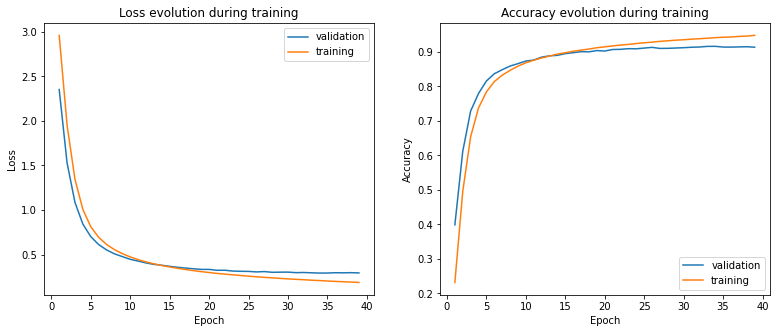

In [ ]:
lr = 1e-4 
batch_size = 63
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_gru_512 = GRUModel(13)

    curves, total_time = train_model(
        model_gru_512,
        train_dataset_512,
        val_dataset_512,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       165
           1       0.86      0.86      0.86       207
           2       0.86      0.88      0.87       185
           3       0.95      0.91      0.93       194
           4       0.89      0.86      0.87       220
           5       0.90      0.90      0.90       406
           6       0.91      0.90      0.90       408
           7       0.89      0.93      0.91       445
           8       0.79      0.82      0.80       172
           9       0.73      0.75      0.74       155
          10       0.87      0.84      0.85       400
          11       0.91      0.86      0.89       402
          12       0.93      0.89      0.91       203
          13       0.94      0.91      0.92       191
          14       0.79      0.82      0.80       161
          15       0.90      0.92      0.91       412
          16       0.96      0.91      0.93       195
          17       0.93    

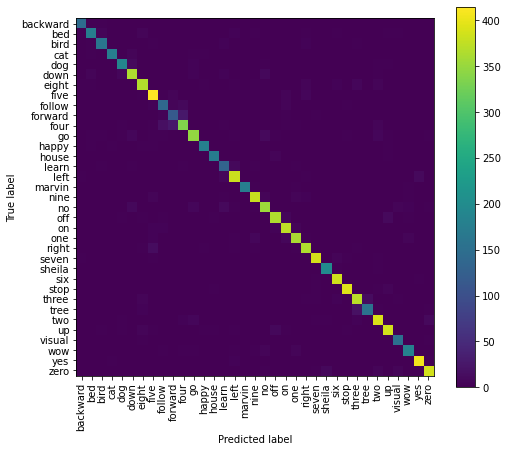

In [ ]:
get_metrics_and_confusion_matrix(model_gru_512, test_dataset_512)

# Modelos Bidireccionales

In [18]:
class BiLSTMModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=128,
        num_layers=1,
    ):
        super().__init__()

        self.rnn_layer = nn.LSTM(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers, bidirectional = True)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, 35),
        )

        self.flatten_layer = nn.Flatten()

    def forward(self, x):
        
        out, (h, c) = self.rnn_layer(x)
            
        out = h[-1]

        return self.net(out)

In [19]:
class BiGRUModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=128,
        num_layers=1,
    ):
        super().__init__()

        self.rnn_layer = nn.GRU(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers, bidirectional = True)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, 35),
        )

        self.flatten_layer = nn.Flatten()

    def forward(self, x):
        
        out, h = self.rnn_layer(x)
            
        out = h[-1]

        return self.net(out)

# Entrenamiento Bidireccional

## Entrenamiento BiLSTM ventanas 512

1347
Epoch 1/50
Iteration 224 - Batch 224/1347 - Train loss: 3.5063992669847277, Train acc: 0.06081128747795415
Iteration 448 - Batch 448/1347 - Train loss: 3.462817551033003, Train acc: 0.08374871849259377
Iteration 672 - Batch 672/1347 - Train loss: 3.4160591461329015, Train acc: 0.10509681832118682
Iteration 896 - Batch 896/1347 - Train loss: 3.3611241197639217, Train acc: 0.12491373360938578
Iteration 1120 - Batch 1120/1347 - Train loss: 3.301504412046189, Train acc: 0.1440748764566784
Iteration 1344 - Batch 1344/1347 - Train loss: 3.2397113013001624, Train acc: 0.16301410279105447
Val loss: 2.8439328216882953, Val acc: 0.28083358380923756
Epoch 2/50
Iteration 1571 - Batch 224/1347 - Train loss: 2.78112953291999, Train acc: 0.2926278659611993
Iteration 1795 - Batch 448/1347 - Train loss: 2.7284945130082705, Train acc: 0.3062537561423976
Iteration 2019 - Batch 672/1347 - Train loss: 2.665650305386638, Train acc: 0.3211160640581146
Iteration 2243 - Batch 896/1347 - Train loss: 2.6054

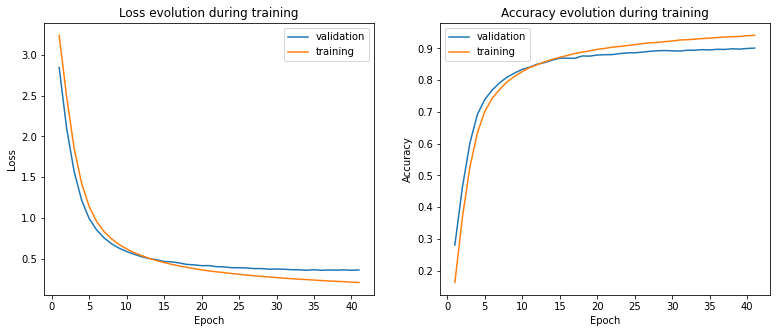

In [ ]:
lr = 1e-4 
batch_size = 63
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_bilstm_512 = BiLSTMModel(13)

    curves, total_time = train_model(
        model_bilstm_512,
        train_dataset_512,
        val_dataset_512,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       165
           1       0.80      0.84      0.82       207
           2       0.83      0.86      0.84       185
           3       0.85      0.87      0.86       194
           4       0.87      0.80      0.83       220
           5       0.89      0.87      0.88       406
           6       0.92      0.90      0.91       408
           7       0.91      0.91      0.91       445
           8       0.81      0.70      0.75       172
           9       0.72      0.76      0.74       155
          10       0.85      0.85      0.85       400
          11       0.81      0.88      0.84       402
          12       0.89      0.92      0.91       203
          13       0.91      0.93      0.92       191
          14       0.77      0.71      0.74       161
          15       0.86      0.90      0.88       412
          16       0.89      0.90      0.90       195
          17       0.90    

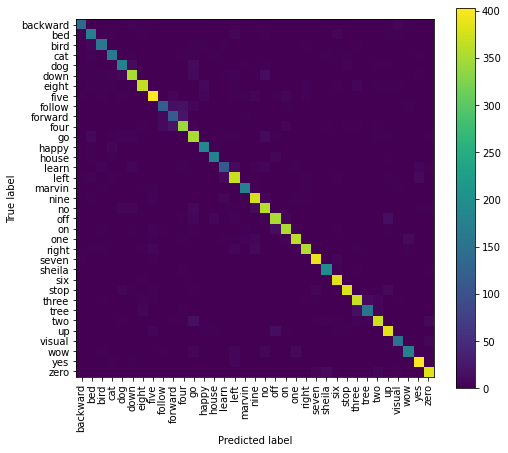

In [ ]:
get_metrics_and_confusion_matrix(model_bilstm_512, test_dataset_512)

## Entrenamiento BiGRU ventanas 512

1347
Epoch 1/50
Iteration 224 - Batch 224/1347 - Train loss: 3.407915087805854, Train acc: 0.10215167548500882
Iteration 448 - Batch 448/1347 - Train loss: 3.265808895595355, Train acc: 0.1578110085905186
Iteration 672 - Batch 672/1347 - Train loss: 3.1411657524675705, Train acc: 0.19533479563197245
Iteration 896 - Batch 896/1347 - Train loss: 3.0269526741576436, Train acc: 0.2255667038275734
Iteration 1120 - Batch 1120/1347 - Train loss: 2.9254340168411024, Train acc: 0.2518584597085935
Iteration 1344 - Batch 1344/1347 - Train loss: 2.8301561850154267, Train acc: 0.27574201923644304
Val loss: 2.2389826865965876, Val acc: 0.43362388538222624
Epoch 2/50
Iteration 1571 - Batch 224/1347 - Train loss: 2.199049482345581, Train acc: 0.44275132275132273
Iteration 1795 - Batch 448/1347 - Train loss: 2.135389917411889, Train acc: 0.4558631173330505
Iteration 2019 - Batch 672/1347 - Train loss: 2.069609535927227, Train acc: 0.47253472959267906
Iteration 2243 - Batch 896/1347 - Train loss: 2.0079

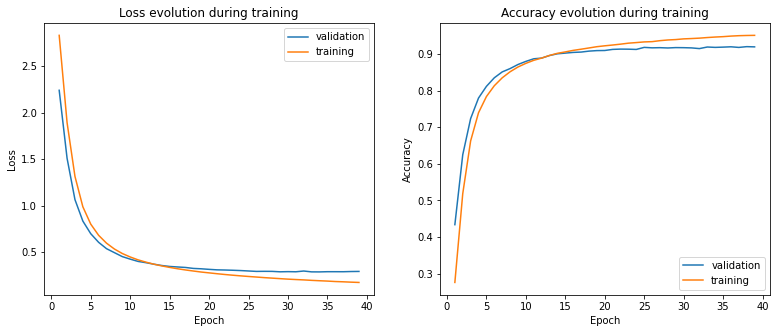

In [ ]:
lr = 1e-4 
batch_size = 63
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_bigru_512 = BiGRUModel(13)

    curves, total_time = train_model(
        model_bigru_512,
        train_dataset_512,
        val_dataset_512,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       165
           1       0.85      0.86      0.85       207
           2       0.88      0.84      0.86       185
           3       0.89      0.89      0.89       194
           4       0.88      0.84      0.86       220
           5       0.88      0.91      0.90       406
           6       0.93      0.91      0.92       408
           7       0.93      0.89      0.91       445
           8       0.87      0.73      0.79       172
           9       0.70      0.65      0.67       155
          10       0.83      0.87      0.85       400
          11       0.86      0.90      0.88       402
          12       0.95      0.93      0.94       203
          13       0.94      0.91      0.92       191
          14       0.74      0.80      0.77       161
          15       0.90      0.93      0.92       412
          16       0.94      0.94      0.94       195
          17       0.93    

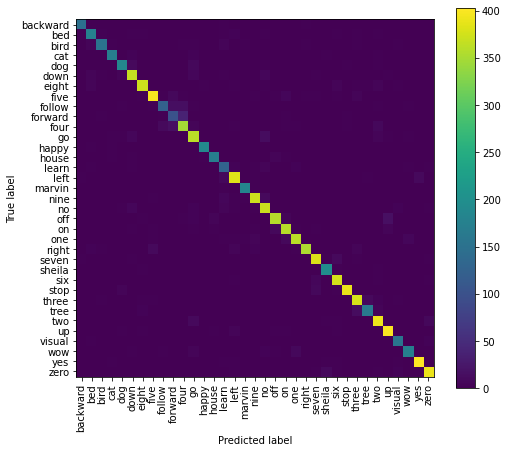

In [ ]:
get_metrics_and_confusion_matrix(model_bigru_512, test_dataset_512)

# Audios con Ruido

In [20]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house',
 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
 'two', 'up', 'visual', 'wow', 'yes', 'zero']

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or "Spectrogram (db)")
  axs.set_ylabel(ylabel)
  axs.set_xlabel("frame")
  im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
  fig.colorbar(im, ax=axs)
  plt.show(block=False)



class Create_DataSet_Noisy(SPEECHCOMMANDS):
  def __init__(self, subset: str = None, ventanas: int = 2048, noise_time = 1):
    super().__init__("./", download=True)

    self.ventanas = ventanas
    self.subset = subset
    self.noise_time = noise_time

    def load_list(filename):
        filepath = os.path.join(self._path, filename)
        with open(filepath) as fileobj:
            return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

    if subset == "validation":
        self._walker = load_list("validation_list.txt")
    elif subset == "testing":
        self._walker = load_list("testing_list.txt")
    elif subset == "training":
        excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
        excludes = set(excludes)
        self._walker = [w for w in self._walker if w not in excludes]


  def get_item_info(self, filepath: str, path: str):
      relpath = os.path.relpath(filepath, path)
      label, filename = os.path.split(relpath)
      speaker, _ = os.path.splitext(filename)
      speaker, _ = os.path.splitext(speaker)

      speaker_id, utterance_number = speaker.split("_nohash_")
      utterance_number = int(utterance_number)

      # Load audio
      waveform, sample_rate = torchaudio.load(filepath)

      largo = waveform.shape[1]
      if largo != 16000:
        pad = (16000 - largo-1, 1)
        waveform = F.pad(waveform, pad, value=0)

      # quitar offset de la señal
      waveform = waveform + abs(waveform.mean())


      # Add noise
      noise = torch.randn(waveform.repeat(1, self.noise_time).shape)

      waveform_rms = waveform.norm(p=2)
      noise_rms = noise.norm(p=2)

      snr_db = 15 #dB del SNR

      snr = 10 ** (snr_db / 20)
      scale = snr * noise_rms / waveform_rms
      
      waveform = torch.cat((noise, (scale * waveform), noise), 1)

      #normalizar señal
      if waveform.max() > -waveform.min():
        waveform = waveform / waveform.max()
      else:
        waveform = waveform / (-waveform.min())


      # MFCC
      n_mfcc = 13
      n_fft = self.ventanas
      win_length = None
      hop_length = int(self.ventanas/2)
      n_mels = 13
      args={"n_fft": n_fft, "n_mels": n_mels, "hop_length": hop_length, "mel_scale": "htk"}

      mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc, melkwargs=args)
      MFCC = mfcc_transform(waveform)


      # Delta
      delta_transform = T.ComputeDeltas()
      Delta = delta_transform(MFCC[0])


      # Delta Delta
      Delta_Delta = delta_transform(Delta)


      clase = torch.tensor(labels.index(label))

      return waveform, MFCC[0], Delta, Delta_Delta, clase





  def __getitem__(self, n: int):
    
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)
    #return torch.cat((info[1], info[2], info[3]), 1), info[4]
    return info[1].T, info[4]


  def plot_wf_and_features(self, n):
    
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)

    plt.plot(info[0].t().numpy())
    plt.title(f"Waveform subset {self.subset}[{n}]")
    plot_spectrogram(info[1], title = f"MFCC subset {self.subset}[{n}]")
    plot_spectrogram(info[2], title = f"Delta subset {self.subset}[{n}]")
    plot_spectrogram(info[3], title = f"Delta-Delta subset {self.subset}[{n}]")

  def get_waveform(self, n: int):
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)

    return info[0]

## Entrenamiento con ventanas de 512 y ruido 1 segundo

In [21]:
# Create training, validation and testing split of the data.

train_dataset_noisy_1 = Create_DataSet_Noisy("training", 512, 1)
val_dataset_noisy_1 = Create_DataSet_Noisy("validation", 512, 1)
test_dataset_noisy_1 = Create_DataSet_Noisy("testing", 512, 1)

In [24]:
# 2do audio del conjunto de prueba sin ruido
waveform_first = train_dataset.get_waveform(1)
ipd.Audio(waveform_first.numpy(), rate=16000)

In [25]:
# 2do audio del conjunto de prueba con ruido
waveform_first = train_dataset_noisy_1.get_waveform(1)
ipd.Audio(waveform_first.numpy(), rate=16000)

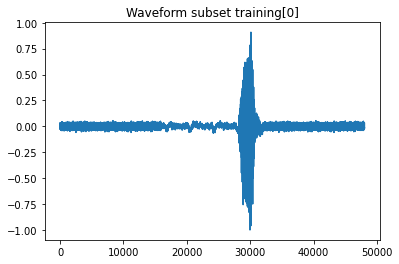

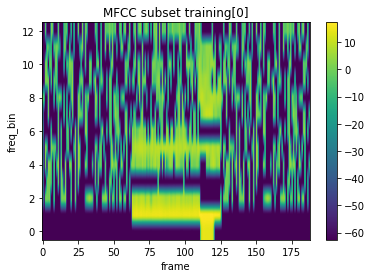

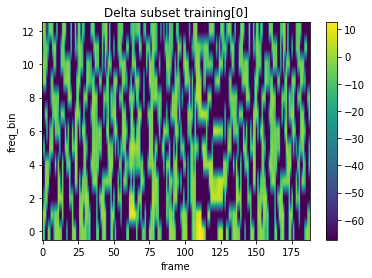

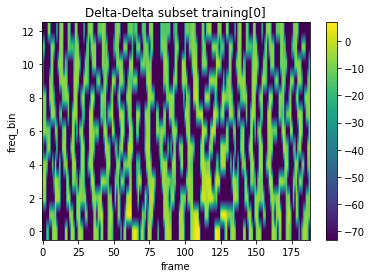

In [ ]:
# Gráfico de onda y features del primer elemento del conjunto de entrenamiento
train_dataset_noisy_1.plot_wf_and_features(0)

### Modelo GRU

452
Epoch 1/50
Iteration 75 - Batch 75/452 - Train loss: 3.536133681472979, Train acc: 0.04073348264277715
Iteration 150 - Batch 150/452 - Train loss: 3.492747699977546, Train acc: 0.050479075665774274
Iteration 225 - Batch 225/452 - Train loss: 3.4690051986052928, Train acc: 0.05476840519676144
Iteration 300 - Batch 300/452 - Train loss: 3.4564753109434516, Train acc: 0.05601894394571287
Iteration 375 - Batch 375/452 - Train loss: 3.4461641539918615, Train acc: 0.057619397917609776
Iteration 450 - Batch 450/452 - Train loss: 3.4404535568474137, Train acc: 0.05886446195216304
Val loss: 3.3930496740957476, Val acc: 0.06602544835186855
Epoch 2/50
Iteration 527 - Batch 75/452 - Train loss: 3.4070985662309745, Train acc: 0.06746920492721165
Iteration 602 - Batch 150/452 - Train loss: 3.409338589535644, Train acc: 0.06671833168944624
Iteration 677 - Batch 225/452 - Train loss: 3.4091041014257786, Train acc: 0.06707776313311994
Iteration 752 - Batch 300/452 - Train loss: 3.4092695008084624, 

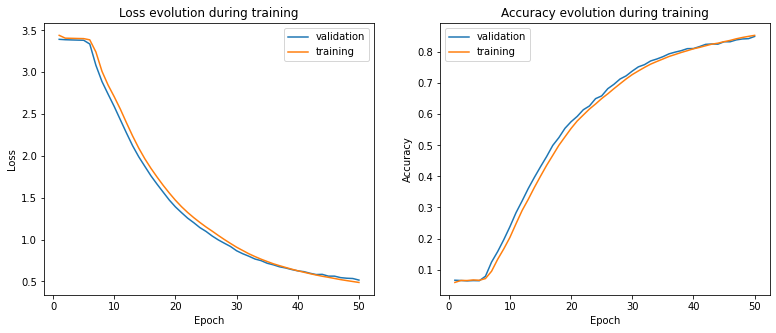

In [ ]:
lr = 1e-4 
batch_size = 188
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_gru_noisy_1 = GRUModel(13)

    curves, total_time = train_model(
        model_gru_noisy_1,
        train_dataset_noisy_1,
        val_dataset_noisy_1,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.66      0.65      0.65       165
           1       0.67      0.81      0.74       207
           2       0.77      0.81      0.79       185
           3       0.77      0.77      0.77       194
           4       0.81      0.70      0.75       220
           5       0.81      0.83      0.82       406
           6       0.93      0.85      0.89       408
           7       0.85      0.88      0.86       445
           8       0.73      0.51      0.60       172
           9       0.54      0.54      0.54       155
          10       0.73      0.82      0.77       400
          11       0.76      0.73      0.74       402
          12       0.84      0.88      0.86       203
          13       0.84      0.86      0.85       191
          14       0.62      0.65      0.64       161
          15       0.87      0.88      0.87       412
          16       0.85      0.71      0.78       195
          17       0.83    

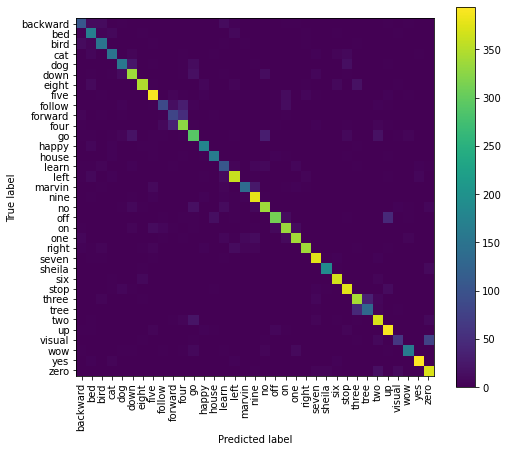

In [ ]:
get_metrics_and_confusion_matrix(model_gru_noisy_1, test_dataset_noisy_1)

### Modelo BiGRU

452
Epoch 1/50
Iteration 75 - Batch 75/452 - Train loss: 3.5468566731402746, Train acc: 0.04059350503919373
Iteration 150 - Batch 150/452 - Train loss: 3.5057892183594355, Train acc: 0.04776666196984641
Iteration 225 - Batch 225/452 - Train loss: 3.4811664883014375, Train acc: 0.05295612878930522
Iteration 300 - Batch 300/452 - Train loss: 3.4662897285828955, Train acc: 0.054958648476708845
Iteration 375 - Batch 375/452 - Train loss: 3.454898512743889, Train acc: 0.05692621095518334
Iteration 450 - Batch 450/452 - Train loss: 3.4474719622711385, Train acc: 0.05812143227815257
Val loss: 3.39315802376658, Val acc: 0.0651237350966837
Epoch 2/50
Iteration 527 - Batch 75/452 - Train loss: 3.401228578467118, Train acc: 0.06907894736842106
Iteration 602 - Batch 150/452 - Train loss: 3.4063163814165733, Train acc: 0.0655910948288009
Iteration 677 - Batch 225/452 - Train loss: 3.408957034085704, Train acc: 0.06498305403878742
Iteration 752 - Batch 300/452 - Train loss: 3.408706388600245, Train 

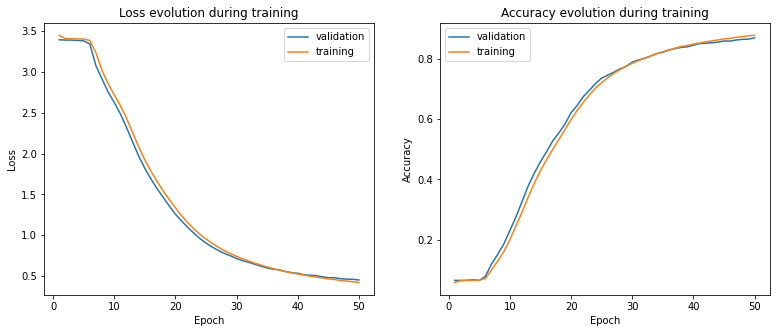

In [ ]:
lr = 1e-4 
batch_size = 188
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_bigru_noisy_1 = BiGRUModel(13)

    curves, total_time = train_model(
        model_bigru_noisy_1,
        train_dataset_noisy_1,
        val_dataset_noisy_1,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       165
           1       0.75      0.78      0.76       207
           2       0.78      0.81      0.79       185
           3       0.84      0.87      0.85       194
           4       0.76      0.74      0.75       220
           5       0.87      0.84      0.86       406
           6       0.90      0.90      0.90       408
           7       0.86      0.88      0.87       445
           8       0.74      0.69      0.72       172
           9       0.59      0.52      0.55       155
          10       0.79      0.83      0.81       400
          11       0.78      0.85      0.81       402
          12       0.83      0.87      0.85       203
          13       0.78      0.88      0.83       191
          14       0.68      0.73      0.70       161
          15       0.90      0.91      0.90       412
          16       0.74      0.75      0.75       195
          17       0.89    

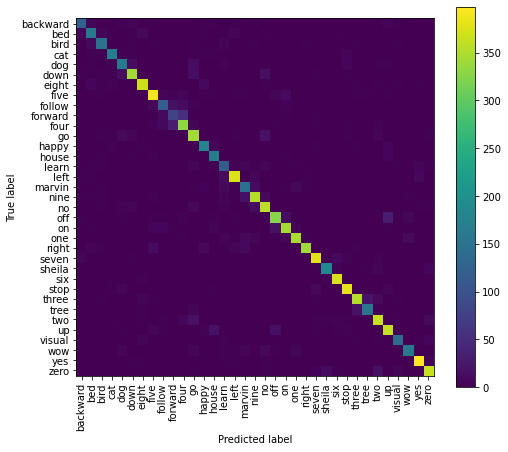

In [ ]:
get_metrics_and_confusion_matrix(model_bigru_noisy_1, test_dataset_noisy_1)

## Entrenamiento con ventanas de 512 y ruido 2 segundos

In [27]:
# Create training, validation and testing split of the data.

train_dataset_noisy_2 = Create_DataSet_Noisy("training", 512, 2)
val_dataset_noisy_2 = Create_DataSet_Noisy("validation", 512, 2)
test_dataset_noisy_2 = Create_DataSet_Noisy("testing", 512, 2)

In [26]:
# 2do audio del conjunto de prueba sin ruido
waveform_first = train_dataset.get_waveform(1)
ipd.Audio(waveform_first.numpy(), rate=16000)

In [28]:
# 2do audio del conjunto de prueba con ruido
waveform_first = train_dataset_noisy_2.get_waveform(1)
ipd.Audio(waveform_first.numpy(), rate=16000)

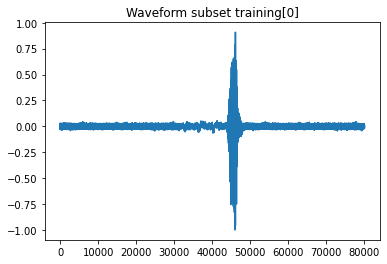

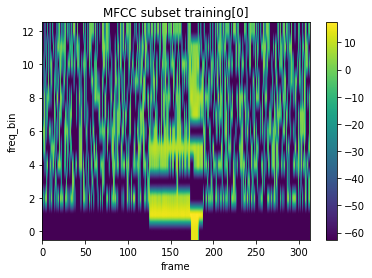

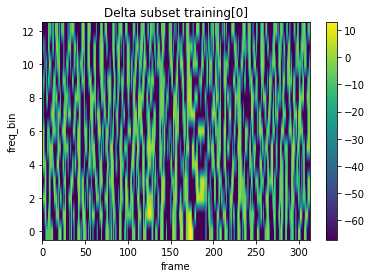

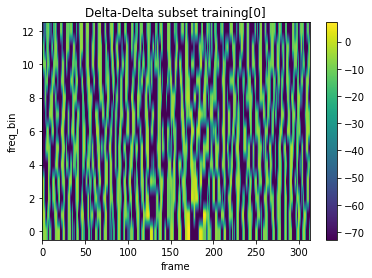

In [34]:
# Gráfico de onda y features del primer elemento del conjunto de entrenamiento
train_dataset_noisy_2.plot_wf_and_features(0)

### Modelo GRU

272
Epoch 1/50
Iteration 45 - Batch 45/272 - Train loss: 3.5674431064854497, Train acc: 0.03861647451034866
Iteration 90 - Batch 90/272 - Train loss: 3.527602793096186, Train acc: 0.04318365340729558
Iteration 135 - Batch 135/272 - Train loss: 3.5018734178122353, Train acc: 0.04653730501785379
Iteration 180 - Batch 180/272 - Train loss: 3.4848161323294455, Train acc: 0.04981201348560535
Iteration 225 - Batch 225/272 - Train loss: 3.472546412881497, Train acc: 0.052220871384545786
Iteration 270 - Batch 270/272 - Train loss: 3.462773092558463, Train acc: 0.05469035521026137
Val loss: 3.399620282245105, Val acc: 0.06362087967137561
Epoch 2/50
Iteration 317 - Batch 45/272 - Train loss: 3.40937964812569, Train acc: 0.06514793721350187
Iteration 362 - Batch 90/272 - Train loss: 3.408562047140939, Train acc: 0.06505634940139733
Iteration 407 - Batch 135/272 - Train loss: 3.4117007781477535, Train acc: 0.06406220635218944
Iteration 452 - Batch 180/272 - Train loss: 3.4111416274012782, Train ac

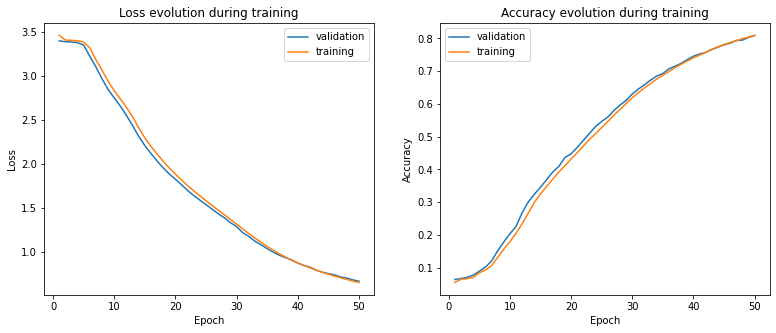

In [ ]:
lr = 1e-4 
batch_size = 313
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_gru_noisy_2 = GRUModel(13)

    curves, total_time = train_model(
        model_gru_noisy_2,
        train_dataset_noisy_2,
        val_dataset_noisy_2,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.51      0.61      0.55       165
           1       0.73      0.72      0.73       207
           2       0.78      0.76      0.77       185
           3       0.70      0.75      0.73       194
           4       0.66      0.61      0.63       220
           5       0.83      0.76      0.79       406
           6       0.89      0.85      0.87       408
           7       0.84      0.85      0.84       445
           8       0.60      0.53      0.57       172
           9       0.60      0.41      0.49       155
          10       0.69      0.78      0.73       400
          11       0.70      0.74      0.72       402
          12       0.77      0.81      0.79       203
          13       0.80      0.88      0.84       191
          14       0.52      0.62      0.57       161
          15       0.82      0.88      0.85       412
          16       0.78      0.69      0.74       195
          17       0.86    

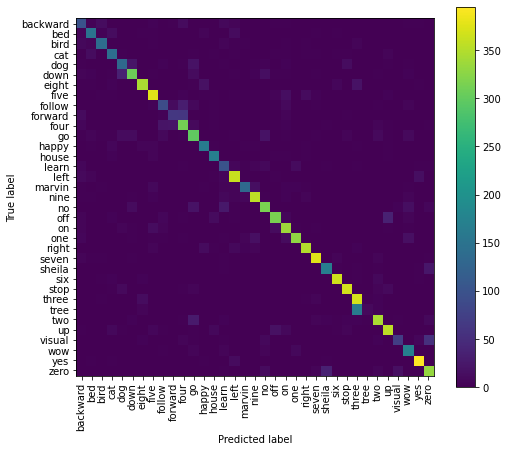

In [ ]:
get_metrics_and_confusion_matrix(model_gru_noisy_2, test_dataset_noisy_2)

### Modelo BiGRU

272
Epoch 1/50
Iteration 45 - Batch 45/272 - Train loss: 3.566953788632932, Train acc: 0.028198360883456036
Iteration 90 - Batch 90/272 - Train loss: 3.5260941353473036, Train acc: 0.039532352631394166
Iteration 135 - Batch 135/272 - Train loss: 3.500204912003349, Train acc: 0.04442304078180793
Iteration 180 - Batch 180/272 - Train loss: 3.4819467502404313, Train acc: 0.048576421372213296
Iteration 225 - Batch 225/272 - Train loss: 3.469945845350755, Train acc: 0.051853317877237126
Iteration 270 - Batch 270/272 - Train loss: 3.460654347585136, Train acc: 0.053617532980441626
Val loss: 3.397033388229353, Val acc: 0.0668269712453662
Epoch 2/50
Iteration 317 - Batch 45/272 - Train loss: 3.4090532219928242, Train acc: 0.06750937630226421
Iteration 362 - Batch 90/272 - Train loss: 3.4061817598866893, Train acc: 0.06477548011094338
Iteration 407 - Batch 135/272 - Train loss: 3.408722740762374, Train acc: 0.06446156737455365
Iteration 452 - Batch 180/272 - Train loss: 3.4089354652067576, Trai

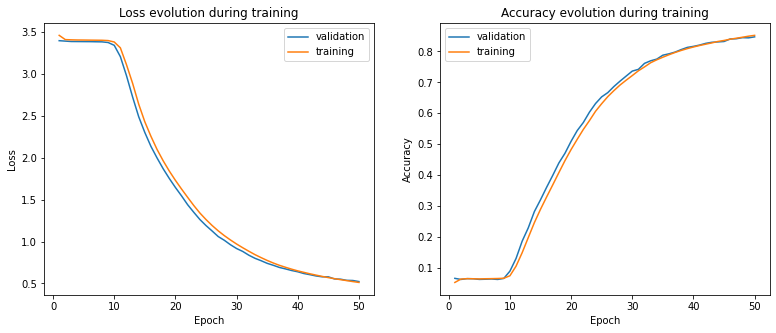

In [ ]:
lr = 1e-4 
batch_size = 313
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_bigru_noisy_2 = BiGRUModel(13)

    curves, total_time = train_model(
        model_bigru_noisy_2,
        train_dataset_noisy_2,
        val_dataset_noisy_2,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.73      0.67      0.70       165
           1       0.69      0.77      0.73       207
           2       0.64      0.77      0.70       185
           3       0.82      0.80      0.81       194
           4       0.77      0.75      0.76       220
           5       0.81      0.80      0.81       406
           6       0.89      0.88      0.88       408
           7       0.84      0.89      0.86       445
           8       0.55      0.60      0.57       172
           9       0.26      0.09      0.13       155
          10       0.66      0.82      0.73       400
          11       0.75      0.82      0.79       402
          12       0.87      0.82      0.84       203
          13       0.85      0.86      0.85       191
          14       0.77      0.68      0.72       161
          15       0.88      0.88      0.88       412
          16       0.76      0.73      0.75       195
          17       0.83    

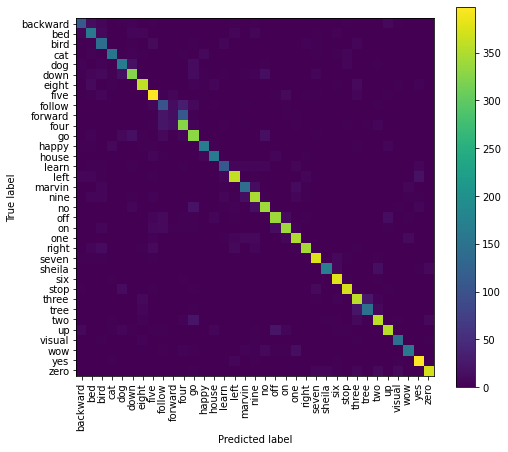

In [ ]:
get_metrics_and_confusion_matrix(model_bigru_noisy_2, test_dataset_noisy_2)

## Entrenamiento con ventanas de 512 y ruido 3 segundos

In [29]:
# Create training, validation and testing split of the data.

train_dataset_noisy_3 = Create_DataSet_Noisy("training", 512, 3)
val_dataset_noisy_3 = Create_DataSet_Noisy("validation", 512, 3)
test_dataset_noisy_3 = Create_DataSet_Noisy("testing", 512, 3)

In [30]:
# 2do audio del conjunto de prueba sin ruido
waveform_first = train_dataset.get_waveform(1)
ipd.Audio(waveform_first.numpy(), rate=16000)

In [31]:
# 2do audio del conjunto de prueba con ruido
waveform_first = train_dataset_noisy_3.get_waveform(1)
ipd.Audio(waveform_first.numpy(), rate=16000)

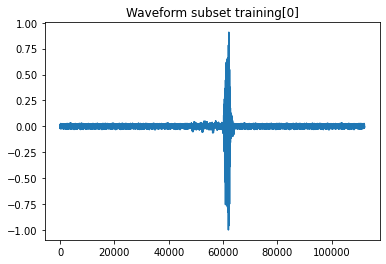

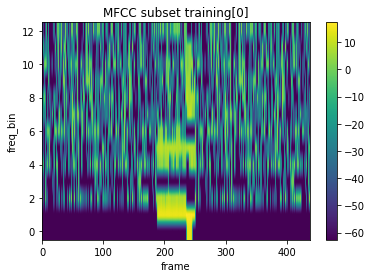

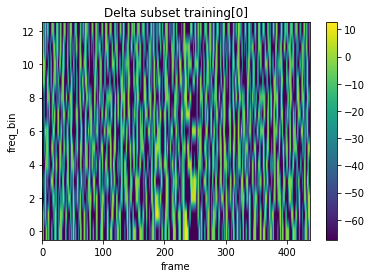

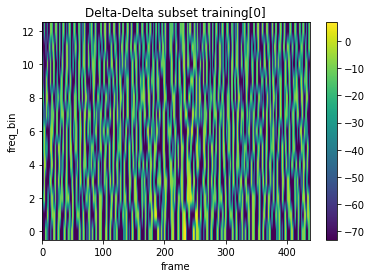

In [35]:
# Gráfico de onda y features del primer elemento del conjunto de entrenamiento
train_dataset_noisy_3.plot_wf_and_features(0)

### Modelo GRU

194
Epoch 1/50
Iteration 32 - Batch 32/194 - Train loss: 3.582325718619607, Train acc: 0.016604400166044003
Iteration 64 - Batch 64/194 - Train loss: 3.5477735299330493, Train acc: 0.02528977871443625
Iteration 96 - Batch 96/194 - Train loss: 3.522395895928452, Train acc: 0.032952031257355366
Iteration 128 - Batch 128/194 - Train loss: 3.5035229172817495, Train acc: 0.039414533998796505
Iteration 160 - Batch 160/194 - Train loss: 3.489791400684333, Train acc: 0.04403131115459882
Iteration 192 - Batch 192/194 - Train loss: 3.4800950134356405, Train acc: 0.04736555705396645
Val loss: 3.410084318104255, Val acc: 0.06612563871355576
Epoch 2/50
Iteration 226 - Batch 32/194 - Train loss: 3.4221861868193657, Train acc: 0.0629583506295835
Iteration 258 - Batch 64/194 - Train loss: 3.418571211741521, Train acc: 0.06350544432736213
Iteration 290 - Batch 96/194 - Train loss: 3.4161300560862746, Train acc: 0.0633620486748576
Iteration 322 - Batch 128/194 - Train loss: 3.416013338769129, Train acc:

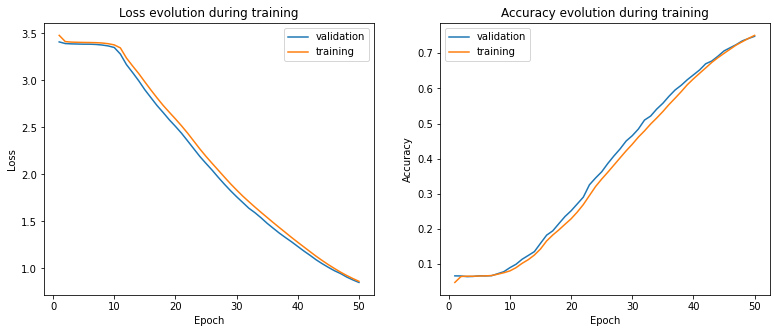

In [ ]:
lr = 1e-4 
batch_size = 438
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_gru_noisy_3 = GRUModel(13)

    curves, total_time = train_model(
        model_gru_noisy_3,
        train_dataset_noisy_3,
        val_dataset_noisy_3,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.29      0.22      0.25       165
           1       0.70      0.71      0.71       207
           2       0.75      0.70      0.72       185
           3       0.71      0.78      0.74       194
           4       0.49      0.40      0.44       220
           5       0.71      0.79      0.75       406
           6       0.91      0.83      0.87       408
           7       0.85      0.76      0.80       445
           8       0.62      0.35      0.45       172
           9       0.43      0.15      0.22       155
          10       0.67      0.80      0.73       400
          11       0.62      0.70      0.66       402
          12       0.84      0.81      0.83       203
          13       0.82      0.83      0.82       191
          14       0.45      0.47      0.46       161
          15       0.79      0.82      0.81       412
          16       0.46      0.21      0.29       195
          17       0.73    

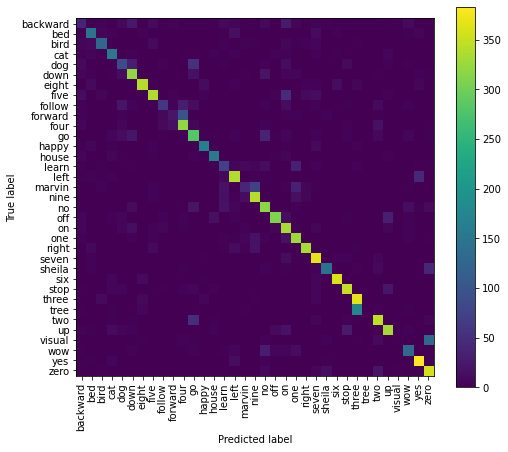

In [ ]:
get_metrics_and_confusion_matrix(model_gru_noisy_3, test_dataset_noisy_3)

### Modelo BiGRU

194
Epoch 1/50
Iteration 32 - Batch 32/194 - Train loss: 3.5539694265885786, Train acc: 0.0341773903417739
Iteration 64 - Batch 64/194 - Train loss: 3.5254791296445407, Train acc: 0.04172813487881981
Iteration 96 - Batch 96/194 - Train loss: 3.507310587106292, Train acc: 0.04563856329143718
Iteration 128 - Batch 128/194 - Train loss: 3.493380923603856, Train acc: 0.049219496654985664
Iteration 160 - Batch 160/194 - Train loss: 3.482520087165122, Train acc: 0.05167474970929408
Iteration 192 - Batch 192/194 - Train loss: 3.473371240141478, Train acc: 0.053493268980528544
Val loss: 3.410937646935213, Val acc: 0.0651237350966837
Epoch 2/50
Iteration 226 - Batch 32/194 - Train loss: 3.4186657775532114, Train acc: 0.06482634564826345
Iteration 258 - Batch 64/194 - Train loss: 3.4163499465355507, Train acc: 0.06519142957499122
Iteration 290 - Batch 96/194 - Train loss: 3.416463058019422, Train acc: 0.0652214847243798
Iteration 322 - Batch 128/194 - Train loss: 3.416510036749433, Train acc: 0.

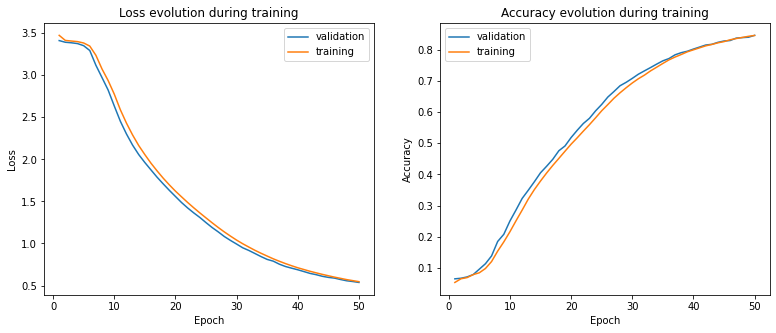

In [ ]:
lr = 1e-4 
batch_size = 438
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_bigru_noisy_3 = BiGRUModel(13)

    curves, total_time = train_model(
        model_bigru_noisy_3,
        train_dataset_noisy_3,
        val_dataset_noisy_3,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

              precision    recall  f1-score   support

           0       0.63      0.67      0.65       165
           1       0.66      0.75      0.70       207
           2       0.68      0.78      0.73       185
           3       0.71      0.89      0.79       194
           4       0.70      0.72      0.71       220
           5       0.77      0.81      0.79       406
           6       0.90      0.87      0.88       408
           7       0.83      0.88      0.86       445
           8       0.64      0.65      0.64       172
           9       0.46      0.36      0.40       155
          10       0.76      0.80      0.78       400
          11       0.72      0.78      0.75       402
          12       0.84      0.87      0.86       203
          13       0.92      0.86      0.89       191
          14       0.69      0.63      0.66       161
          15       0.85      0.89      0.87       412
          16       0.79      0.78      0.79       195
          17       0.87    

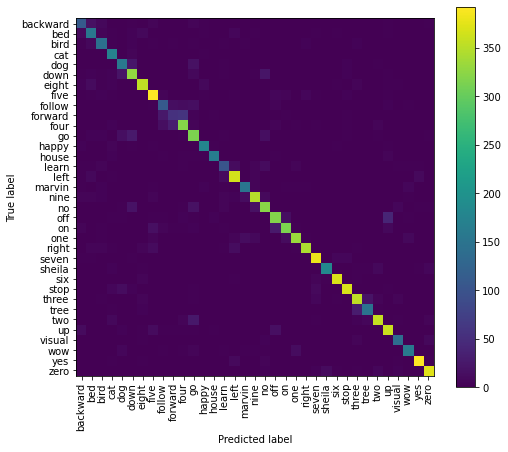

In [ ]:
get_metrics_and_confusion_matrix(model_bigru_noisy_3, test_dataset_noisy_3)